# Step 3: SDG

In [6]:
# necessary imports for the section
from sdv.single_table import CTGANSynthesizer as CTGAN

import pickle
import pandas as pd 
import os 
import sys

sys.path.append('../src')
from utils import (getPicklesFromDir, 
                   getExperimentConfig, 
                   extract_loss_info_from_stdout, 
                   create_loss_plot)

from mlflow_manager import MLFlowManager

# Get global experiment settings
config = getExperimentConfig()
# Get folders
folders = config['folders']
# Get dataset specific settings
dataset_settings = getPicklesFromDir(folders['settings_dir'])

ModuleNotFoundError: No module named 'sdv.single_table'

In [4]:
%%capture stdout_loss

# Specify datasets by Id, if None, all is run
run_dataset = config['run_dataset']

# get settings
quality_params = config['ctgan_param']['quality_params']
sd_size_factor = config['ctgan_param']['sd_size_factor']
num_SD = config['ctgan_param']['num_sd']


# run SDG generation
# for each dataset specific settings
for s_index, settings in enumerate(dataset_settings):
    
    if run_dataset is not None and settings['meta']['id'] not in run_dataset:
        continue
    
    # Init experiment logging
    experiment_name = f"{settings['meta']['id']}-SDG-models"
    mlflow = MLFlowManager(experiment_name)
    
    # load original dataset
    original_data = pd.read_csv(folders['real_dir'] + settings['meta']['filename'])  
    
    # get the size to generate the synthetic data
    original_data_size = len(original_data)
    sd_size = original_data_size * sd_size_factor
    
    logg_tags = {'Source': settings['meta']['id']}
    
    # loop through the different quality parameters for the SDG
    for quality in quality_params:
        
        logg_tags['Quality'] = quality
        
        sdg_name = f"S{settings['meta']['id']}{quality}"
        log_run = mlflow.start_run(sdg_name, tags=logg_tags)
        mlflow.log_params(quality_params[quality])
        
        # creates model with sdg_param and quality_param as parameters
        print("#START#")   # for capturing loss info
        
        model = CTGAN(**settings['sdg_param'], **quality_params[quality])
        
        print(sdg_name)   # for capturing loss info
        model.fit(original_data)
        
        # saves the SDG model using cloudpickle
        model_file = f"{sdg_name}.pkl"
        model.save(model_file) 
        mlflow.log_artifact(model_file)
        
        if os.path.isfile(model_file):
            os.remove(model_file)
        
        print("#END#")   # for capturing loss info
        mlflow.end_run()
        
        # create num_SD SDGs and synthetic datasets for validating results
        for itr in range(num_SD):
            
            # creates Synthetic dataset name, using datset id, quality key, and itr number 
            # e.g. SD1Q1_2 means SDG trained on datset D1 with quality Q1 and copy num 2
            SD_name = f"S{settings['meta']['id']}{quality}_{str(itr)}"
            
            # relative file path for the synthetic dataset
            sd_path = f"{folders['sd_dir']}{SD_name}.csv"
            
            # generate synthetic data
            synthetic_data = model.sample(num_rows=sd_size)
            
            # save the synthetic dataset
            synthetic_data.to_csv(sd_path, index=False)
            
    mlflow.end_run()

KeyboardInterrupt: 

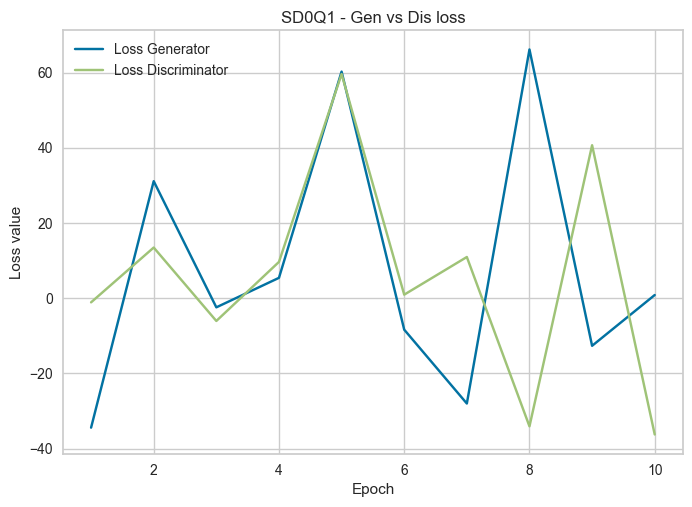

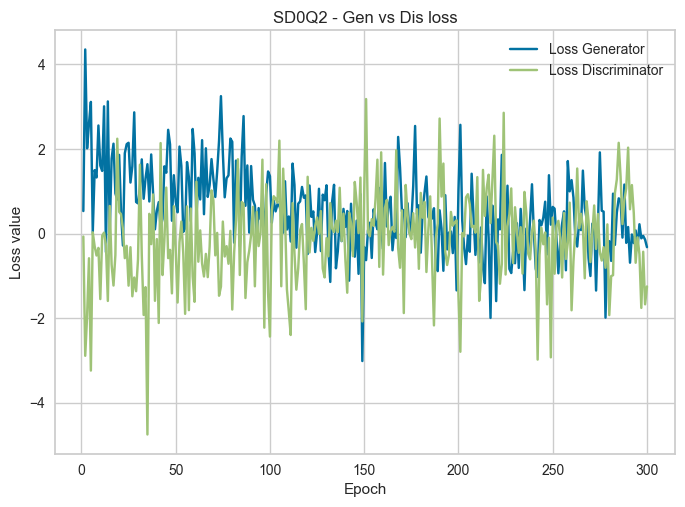

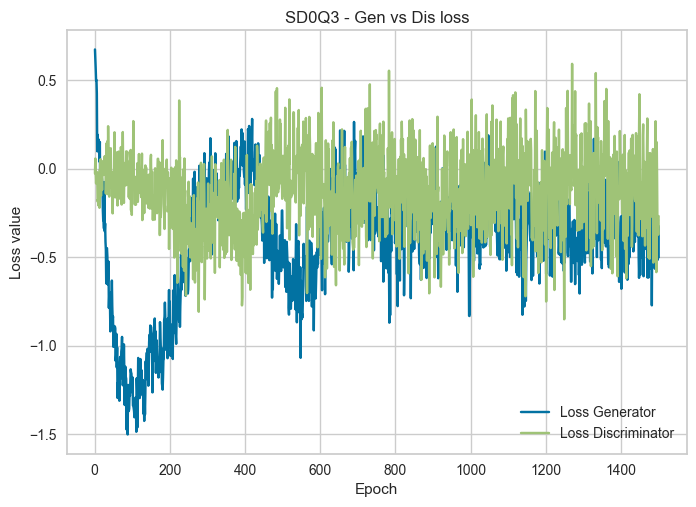

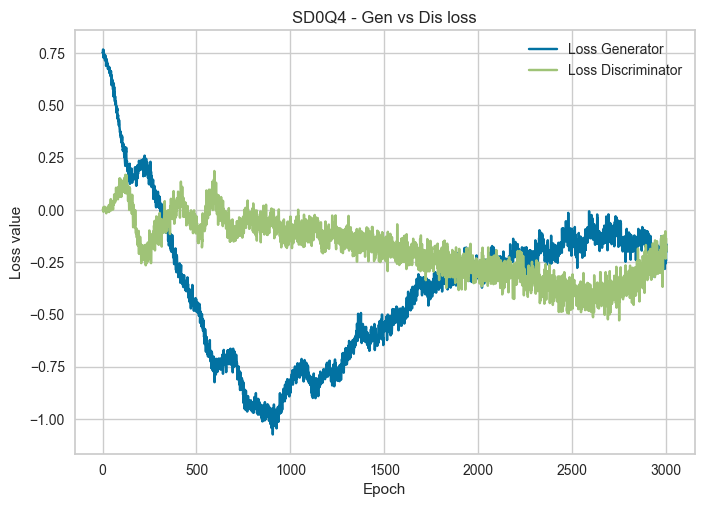

In [3]:
""" The Loss values captured from the cell above's standard output will 
be used to create the generator vs discriminator loss plots.
"""
loss_values = extract_loss_info_from_stdout(stdout_loss.stdout)
# Combine the loss values and save them
combined_loss_df = pd.concat(loss_values.values(), keys=loss_values.keys(), axis=0, ignore_index=False)
combined_loss_df = combined_loss_df.reset_index().rename(columns={'level_0': 'SDG'})
combined_loss_df.to_csv(f"{folders['data_dir']}combined_sdg_loss.csv", index=False)

for sdg_id in loss_values:
    fig = create_loss_plot(sdg_id, loss_values[sdg_id])
    # Save the plot to correct mlflow log
    run=mlflow.load_run_by_name(sdg_id)
    path=run.info.artifact_uri.replace("file:///", "")
    #save plot
    fig.savefig(f"{path}/{sdg_id}_loss_plot.png")
    #save data
    loss_values[sdg_id].to_csv(f"{path}/{sdg_id}.csv", index=False)
    

---